<a href="https://colab.research.google.com/github/s1230038/googleColaboScrapbook/blob/master/MLproject2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""

"""
!wget "https://drive.google.com/uc?export=download&id=1c_pDTglnOZO46i4Zx5l71eaWbelDHgT1" -O experiment.py
!wget "https://drive.google.com/uc?export=download&id=1K6kSN7CdCl22Y6PUDMRbz-gLFfvsF93G" -O draw.py
!wget "https://drive.google.com/uc?export=download&id=1Ysoy4oZ_U040VerC_DyND-2T_ifsPDtt" -O MLP.py
!wget "https://drive.google.com/uc?export=download&id=1P6LsE4vV-lfnY6Bwbm_1sZ-CGtEaBjOB" -O AE.py

# !rm *.py
!ls

--2019-07-30 00:15:24--  https://drive.google.com/uc?export=download&id=1c_pDTglnOZO46i4Zx5l71eaWbelDHgT1
Resolving drive.google.com (drive.google.com)... 74.125.141.101, 74.125.141.138, 74.125.141.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.141.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-40-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lq5hgfji1nkcpfmh8d1ll09e3dhv9am0/1564444800000/01373940132919773772/*/1c_pDTglnOZO46i4Zx5l71eaWbelDHgT1?e=download [following]
--2019-07-30 00:15:24--  https://doc-0s-40-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lq5hgfji1nkcpfmh8d1ll09e3dhv9am0/1564444800000/01373940132919773772/*/1c_pDTglnOZO46i4Zx5l71eaWbelDHgT1?e=download
Resolving doc-0s-40-docs.googleusercontent.com (doc-0s-40-docs.googleusercontent.com)... 74.125.141.132, 2607:f8b0:400c:c06::84
Connecting to doc-0s-40-docs.googleusercontent.com (doc-0s

In [0]:
# AE.py

import math
import numpy as np
import chainer
from chainer import Function, FunctionNode, gradient_check, report, training, utils, Variable
from chainer import datasets, initializers, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions


class AutoEncoder(Chain):
    def __init__(self, n_in, n_mid_units=100):
        super(AutoEncoder, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(n_in, n_mid_units)
            self.l2 = L.Linear(n_mid_units, n_in)

    def forward(self, x):
        h1 = self.l1(x)
        return self.l2(h1)

    def compress(self, x):
        return self.l1(x)

gpu_id = 0

def prepare(train, test):
    ae_train = [(d[0].flatten(), d[0].flatten()) for d in train]
    ae_test = [(d[0].flatten(), d[0].flatten()) for d in test]

    dim = len(ae_train[0][0])
    model = AutoEncoder(dim, n_mid_units=dim // 10)

    if gpu_id >= 0:
        model.to_gpu(gpu_id)

    return ae_train, ae_test, model


def train_model(model, train, outdir, max_epoch):
    batchsize = 128
    train_iter = iterators.SerialIterator(train, batchsize)

    wrapper = L.Classifier(model, lossfun=F.mean_squared_error)
    wrapper.compute_accuracy = False

    optimizer = optimizers.MomentumSGD()
    optimizer.setup(wrapper)

    updater = training.updaters.StandardUpdater(
        train_iter, optimizer, device=gpu_id)
    trainer = training.Trainer(
        updater, (max_epoch, 'epoch'), out=outdir)

    from chainer.training import extensions

    trainer.extend(extensions.LogReport())
    trainer.extend(
        extensions.snapshot_object(
            wrapper.predictor, filename='model-{.updater.epoch}'))
    trainer.extend(
        extensions.PrintReport(['epoch', 'main/loss', 'elapsed_time']))
    trainer.extend(
        extensions.PlotReport(['main/loss'],
                              x_key='epoch',
                              file_name='loss.png'))

    trainer.run()

def reconstruct(train, test, outdir, max_epoch):
    ae_train, ae_test, model = prepare(train, test)
    train_model(model, ae_train, outdir, max_epoch)


def get_compressed_dataset(train, test, model_dir, max_epoch):
    ae_train, ae_test, model = prepare(train, test)
    serializers.load_npz(
        '{}/model-{}'.format(model_dir, max_epoch),
        model)

    mlp_train = [(model.compress(chainer.cuda.to_gpu(
        d[0][np.newaxis, :])).data[0], d[1]) for d in train]
    mlp_test = [(model.compress(chainer.cuda.to_gpu(
        d[0][np.newaxis, :])).data[0], d[1]) for d in test]

    return mlp_train, mlp_test


if __name__ == '__main__':
    import sys
    import chainer.datasets

    args = sys.argv
    assert(len(args) >= 2)

    args[1] = 'cifar10' # Modified
    
    if args[1] == 'mnist':
        train, test = chainer.datasets.get_mnist(ndim=2)

    if args[1] == 'cifar10':
        train, test = chainer.datasets.get_cifar10(ndim=3)

    if args[1] == 'cifar100':
        train, test = chainer.datasets.get_cifar100(ndim=3)


    outdir = 'reconstruct_{}'.format(args[1])
    reconstruct(train, test, outdir, 500)


epoch       main/loss   elapsed_time
1           0.193208    1.46211       
2           0.061067    3.49489       
3           0.0533764   7.38669       
4           0.0514259   9.45716       
5           0.0500169   11.5117       
6           0.0488526   13.5424       
7           0.0478755   15.6343       
8           0.0469862   17.6625       
9           0.046164    19.7191       
10          0.0453796   21.7549       
11          0.0446321   23.7992       
12          0.0438939   25.8369       
13          0.043188    27.9072       
14          0.0424762   29.9437       
15          0.0417893   31.9767       
16          0.0411101   34.0291       
17          0.0404538   36.0633       
18          0.0398051   38.1923       
19          0.0391885   40.2525       
20          0.0385903   42.3159       
21          0.0380175   44.3632       
22          0.0374592   46.4253       
23          0.0369444   48.4717       
24          0.0364443   50.4914       
25          0.0359713   52.

In [0]:
# MLP.py
import math
import numpy as np
import chainer
from chainer import Function, FunctionNode, gradient_check, report, training, utils, Variable
from chainer import datasets, initializers, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions


class MLP(Chain):
    def __init__(self, n_mid_units=100, n_out=10):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_mid_units)
            self.l2 = L.Linear(None, n_mid_units)
            self.l3 = L.Linear(None, n_out)

    def forward(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)


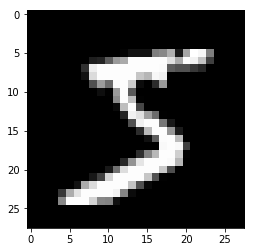

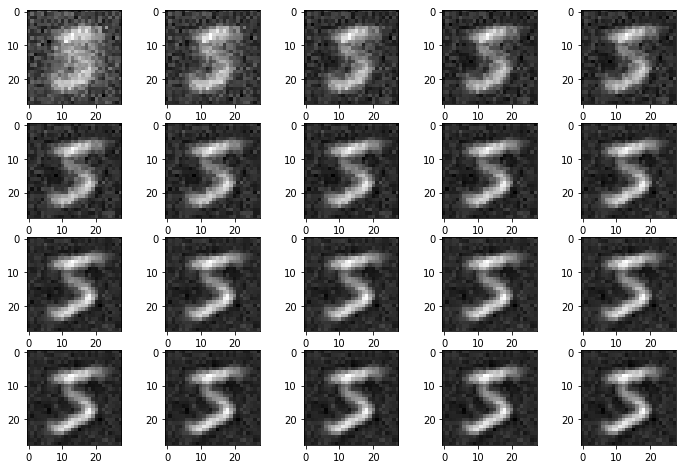

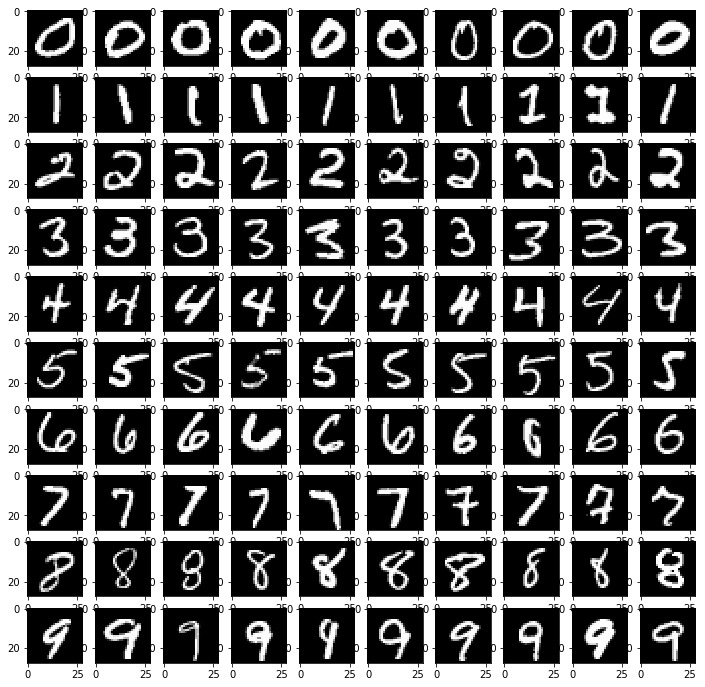

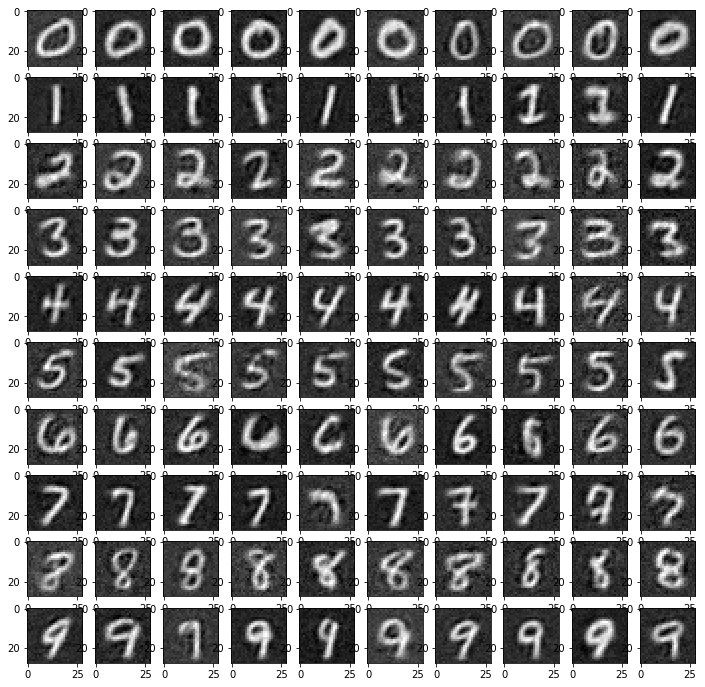

In [0]:
# draw.py
import matplotlib.pyplot as plt
import math
import numpy as np
import chainer
from chainer import Function, FunctionNode, gradient_check, report, training, utils, Variable
from chainer import datasets, initializers, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
import AE
from chainer.training import extensions

gpu_id = 0
def forward(model, datum):
    if gpu_id >= 0:
        dat = chainer.cuda.to_gpu(datum[np.newaxis, :])
        img = model.forward(dat)
        img = chainer.cuda.to_cpu(img.data[0])
    else:
        img = model.forward(datum[np.newaxis, :].data)

    return img


def draw_gray(train, test, model_dir, max_epoch, figdir):
    ae_train, ae_test, model = AE.prepare(train, test)

    fig1, ax1 = plt.subplots()
    ax1.imshow(train[0][0], cmap="gray")

    fig2 = plt.figure(figsize=(12, 8))

    for i in range(20):
        serializers.load_npz(
            '{}/model-{}'.format(model_dir, (i + 1) * (max_epoch // 20)),
            model)

        img = forward(model, ae_train[0][0])
        ax = fig2.add_subplot(4, 5, i + 1)
        ax.imshow(img.reshape(28, 28), cmap="gray")

    idxs = dict()
    for i, d in enumerate(test):
        if not d[1] in idxs:
            idxs[d[1]] = list()
        idxs[d[1]].append(i)

    serializers.load_npz('{}/model-{}'.format(model_dir, max_epoch), model)

    fig3 = plt.figure(figsize=(12, 12))
    fig4 = plt.figure(figsize=(12, 12))
    for i in range(10):
        np.random.shuffle(idxs[i])
        for j, idx in enumerate(idxs[i][:10]):
            ax = fig3.add_subplot(10, 10, i * 10 + j + 1)
            ax.imshow(test[idx][0], cmap="gray")

            img = forward(model, ae_test[idx][0])
            ax = fig4.add_subplot(10, 10, i * 10 + j + 1)
            ax.imshow(img.reshape(28, 28), cmap="gray")

    for i, f in enumerate(plt.get_fignums()):
        plt.figure(f)
        plt.savefig('figures/{}/fig{}.png'.format(figdir, i))


def draw_color(train, test, model_dir, max_epoch, figdir):
    ae_train, ae_test, model = AE.prepare(train, test)

    fig1, ax1 = plt.subplots()
    ax1.imshow(train[0][0].transpose(1, 2, 0))

    fig2 = plt.figure(figsize=(12, 8))

    for i in range(20):
        serializers.load_npz(
            '{}/model-{}'.format(model_dir, (i + 1) * (max_epoch // 20)),
            model)

        img = forward(model, ae_train[0][0])
        ax = fig2.add_subplot(4, 5, i + 1)
        ax.imshow(img.reshape(3, 32, 32).transpose(1, 2, 0))

    idxs = dict()
    for i, d in enumerate(test):
        if not d[1] in idxs:
            idxs[d[1]] = list()
        idxs[d[1]].append(i)

    serializers.load_npz('{}/model-{}'.format(model_dir, max_epoch), model)

    fig3 = plt.figure(figsize=(12, 12))
    fig4 = plt.figure(figsize=(12, 12))
    for i in range(10):
        np.random.shuffle(idxs[i])
        for j, idx in enumerate(idxs[i][:10]):
            ax = fig3.add_subplot(10, 10, i * 10 + j + 1)
            ax.imshow(test[idx][0].transpose(1, 2, 0))

            img = forward(model, ae_test[idx][0])
            ax = fig4.add_subplot(10, 10, i * 10 + j + 1)
            ax.imshow(img.reshape(3, 32, 32).transpose(1, 2, 0))

    for i, f in enumerate(plt.get_fignums()):
        plt.figure(f)
        plt.savefig('figures/{}/fig{}.png'.format(figdir, i))

if __name__ == '__main__':
    import sys

    args = sys.argv
    assert(len(args) >= 2)

    if args[1] == 'mnist':
        train, test = chainer.datasets.get_mnist(ndim=2)
        draw_gray(train, test, 'reconstruct_mnist', 500, args[1])

    if args[1] == 'cifar10':
        train, test = chainer.datasets.get_cifar10(ndim=3)
        draw_color(train, test, 'reconstruct_cifar10', 500, args[1])

    if args[1] == 'cifar100':
        train, test = chainer.datasets.get_cifar100(ndim=3)
        draw_color(train, test, 'reconstruct_cifar100', 500, args[1])


In [0]:
# experiment.py

import math
import numpy as np
import chainer
from chainer import Function, FunctionNode, gradient_check, report, training, utils, Variable
from chainer import datasets, initializers, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions

import AE, MLP
import chainer.datasets

def evaluate(train, test, outdir, max_epoch, n_mid_units=100):
    class_num = len(set([d[1] for d in test]))

    batchsize = 128
    train_iter = iterators.SerialIterator(train, batchsize)
    test_iter = iterators.SerialIterator(test, batchsize, False, False)

    model = MLP.MLP(n_mid_units=n_mid_units, n_out=class_num)

    gpu_id = 0
    if gpu_id >= 0:
        model.to_gpu(gpu_id)

    model = L.Classifier(model)

    optimizer = optimizers.MomentumSGD()
    optimizer.setup(model)

    updater = training.updaters.StandardUpdater(
        train_iter, optimizer, device=gpu_id)
    trainer = training.Trainer(updater, (max_epoch, 'epoch'), out=outdir)

    from chainer.training import extensions

    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
    trainer.extend(
        extensions.PrintReport([
            'epoch', 'main/loss', 'main/accuracy', 'validation/main/loss',
            'validation/main/accuracy', 'elapsed_time'
        ]))
    trainer.extend(
        extensions.PlotReport(['main/loss', 'validation/main/loss'],
                              x_key='epoch',
                              file_name='loss.png'))
    trainer.extend(
        extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                              x_key='epoch',
                              file_name='accuracy.png'))

    trainer.run()


if __name__ == '__main__':
    import sys
    import chainer.datasets

    args = sys.argv
    assert(len(args) >= 3)

    if args[1] == 'mnist':
        train, test = chainer.datasets.get_mnist(ndim=2)

    if args[1] == 'cifar10':
        train, test = chainer.datasets.get_cifar10(ndim=3)

    if args[1] == 'cifar100':
        train, test = chainer.datasets.get_cifar100(ndim=3)

    args[2] = 'AE' #modifid
        
    use_AE = (args[2] == 'AE')
    if use_AE:
        outdir = 'reconstruct_{}'.format(args[1])
        max_epoch = 500
        train, test = AE.get_compressed_dataset(train, test, outdir, max_epoch)
        evaluate(train, test, 'mlp_with_ae_{}'.format(args[1]), 100)
    else:
        evaluate(train, test, 'mlp_only_{}'.format(args[1]), 100)


epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           0.561532    0.835938       0.265811              0.923358                  7.69326       
2           0.243333    0.929887       0.19494               0.942148                  10.0444       
3           0.185179    0.945762       0.163524              0.950257                  12.4383       
4           0.14959     0.956163       0.142225              0.955498                  14.8669       
5           0.124315    0.964119       0.112588              0.965289                  17.25         
6           0.106333    0.969566       0.113247              0.964992                  19.6692       
7           0.0925951   0.972298       0.0954638             0.970728                  22.1246       
8           0.0820357   0.976345       0.0930337             0.970332                  24.5319       
9           0.0726441   0.979011       0.0809191             0.974189               

In [0]:
!mkdir -p figures/mnist/
!mkdir -p figures/cifar10/
!mkdir -p figures/cifar100/

In [0]:

print("  AE.py mnist")
!python3 AE.py mnist
print("  AE.py cifar10")
!python3 AE.py cifar10
print("  AE.py cifar100")
!python3 AE.py cifar100
print("--------")


print("  draw.py mnist")
!python3 draw.py mnist
print("  draw.py cifar10")
!python3 draw.py cifar10
print("  draw.py cifar100")
!python3 draw.py cifar100
print("--------")

print("  experiment.py mnist AE")
!python3 experiment.py mnist AE
print("  experiment.py mnist mlp_only")
!python3 experiment.py mnist mlp_only
print("  experiment.py cifar10 AE")
!python3 experiment.py cifar10 AE
print("  experiment.py cifar10 mlp_only")
!python3 experiment.py cifar10 mlp_only
print("  experiment.py cifar100 AE")
!python3 experiment.py cifar100 AE
print("  experiment.py cifar100 mlp_only")
!python3 experiment.py cifar100 mlp_only


  AE.py mnist
epoch       main/loss   elapsed_time
1           0.127943    5.84253       
2           0.0975382   7.67383       
3           0.0826681   9.42611       
4           0.0731653   11.2657       
5           0.0676743   13.0983       
6           0.0646215   14.8981       
7           0.062811    16.6573       
8           0.0615882   18.3841       
9           0.0606408   20.1236       
10          0.0598187   21.8972       
11          0.0590655   23.6963       
12          0.0583318   25.5077       
13          0.0576306   27.349        
14          0.056927    29.0868       
15          0.0562437   30.8451       
16          0.0555471   32.6467       
17          0.0548548   34.4297       
18          0.0541562   36.1742       
19          0.0534683   37.952        
20          0.052768    39.7264       
21          0.0520814   41.5337       
22          0.0513959   43.291        
23          0.0507203   45.0469       
24          0.0500423   46.8199       
25          0

In [0]:
!ls -lh


total 6.8G
-rw-r--r-- 1 root root 3.1K Jul 28 09:29 AE.py
-rw-r--r-- 1 root root 3.9K Jul 28 09:29 draw.py
-rw-r--r-- 1 root root 2.5K Jul 28 09:28 experiment.py
drwxr-xr-x 5 root root 4.0K Jul 28 09:16 figures
-rw-r--r-- 1 root root 2.3M Jul 28 11:22 figures.zip
drwxr-xr-x 2 root root 4.0K Jul 28 11:14 mlp_only_cifar10
drwxr-xr-x 2 root root 4.0K Jul 28 11:22 mlp_only_cifar100
drwxr-xr-x 2 root root 4.0K Jul 28 09:41 mlp_only_mnist
-rw-r--r-- 1 root root  760 Jul 28 09:29 MLP.py
drwxr-xr-x 2 root root 4.0K Jul 28 11:10 mlp_with_ae_cifar10
drwxr-xr-x 2 root root 4.0K Jul 28 11:18 mlp_with_ae_cifar100
drwxr-xr-x 2 root root 4.0K Jul 28 09:37 mlp_with_ae_mnist
-rw-r--r-- 1 root root 437K Jul 28 11:22 mlp.zip
drwxr-xr-x 2 root root 4.0K Jul 28 09:30 __pycache__
drwxr-xr-x 2 root root  20K Jul 28 10:44 reconstruct_cifar10
drwxr-xr-x 2 root root  20K Jul 28 11:05 reconstruct_cifar100
drwxr-xr-x 2 root root  20K Jul 28 07:09 reconstruct_mnist
-rw-r--r-- 1 root root 6.8G Jul 28 11:27 reconstr

In [0]:
from google.colab import files

!zip -r mlp.zip mlp*
!zip -r figures.zip figures*


!cp reconstruct_mnist/loss.png mnist_loss.png
!cp reconstruct_cifar10/loss.png cifar10_loss.png
!cp reconstruct_cifar100/loss.png cifar100_loss.png
!zip -r loss.png.zip *_loss.png
!ls -lh 

files.download('mlp.zip')
files.download('figures.zip')
files.download('loss.png.zip')